In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scapy.all import rdpcap, ARP
import numpy as np



Отравление 0.0.0.0 несколько mac-adress.
Отравление 192.168.1.63 несколько mac-adress.
Отравление 192.168.1.1 несколько mac-adress.
        src_ip        dst_ip            src_mac            dst_mac  op_type  \
0  192.168.1.1  192.168.1.72  00:ad:24:bf:9d:52  00:00:00:00:00:00        1   
1  192.168.1.1  192.168.1.72  00:ad:24:bf:9d:52  00:00:00:00:00:00        1   
2  192.168.1.1  192.168.1.72  00:ad:24:bf:9d:52  00:00:00:00:00:00        1   
3  192.168.1.1  192.168.1.15  00:ad:24:bf:9d:52  00:00:00:00:00:00        1   
4  192.168.1.1  192.168.1.15  00:ad:24:bf:9d:52  00:00:00:00:00:00        1   

          time_delta  label  
0  1737294233.933342      0  
1  1737294259.323055      0  
2  1737294324.446376      0  
3  1737294328.956137      0  
4  1737294329.873696      0  


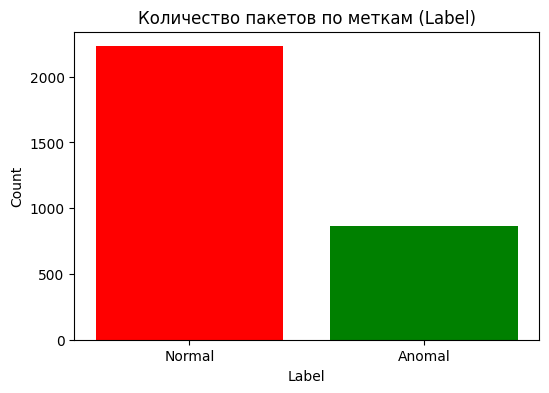

In [3]:
# Чтение pcapng файлов
normal_traffic = rdpcap(r'D:\Проекты\Дипломаня работа\DoFitN\Data\arp_N.pcapng')
anomaly_traffic = rdpcap(r'D:\Проекты\Дипломаня работа\DoFitN\Data\arp_A.pcapng')

# Фильтрация ARP пакетов
normal_arp_packets = [pkt for pkt in normal_traffic if ARP in pkt]
anomaly_arp_packets = [pkt for pkt in anomaly_traffic if ARP in pkt]

# Функция для детекции ARP poisoning
def detect_arp_poisoning(arp_packets):
    ip_mac = {}
    for pkt in arp_packets:
        ip = pkt[ARP].psrc
        mac = pkt[ARP].hwsrc
        
        if ip in ip_mac:
            if mac not in ip_mac[ip]:
                print(f"Отравление {ip} несколько mac-adress.")
                ip_mac[ip].append(mac)
        else:
            ip_mac[ip] = [mac]

# Анализ нормального трафика
detect_arp_poisoning(normal_arp_packets)

# Анализ аномального трафика
detect_arp_poisoning(anomaly_arp_packets)

# Извлечение признаков
def extract_features(packets, label):
    data = []
    
    for pkt in packets:
        if ARP in pkt:
            src_ip = pkt[ARP].psrc
            dst_ip = pkt[ARP].pdst
            src_mac = pkt[ARP].hwsrc
            dst_mac = pkt[ARP].hwdst
            op_type = pkt[ARP].op  # Тип запроса ARP (1 - запрос, 2 - ответ)
            time_delta = pkt.time  # Время получения пакета
            
            data.append([src_ip, dst_ip, src_mac, dst_mac, op_type, time_delta, label])
    
    return data

# Фильтрация и извлечение данных
normal_arp_packets = [pkt for pkt in normal_traffic if ARP in pkt]
anomaly_arp_packets = [pkt for pkt in anomaly_traffic if ARP in pkt]

# Признаки для нормального трафика (метка 0)
normal_data = extract_features(normal_arp_packets, label=0)

# Признаки для аномального трафика (метка 1)
anomaly_data = extract_features(anomaly_arp_packets, label=1)

# Создание DataFrame
columns = ['src_ip', 'dst_ip', 'src_mac', 'dst_mac', 'op_type', 'time_delta', 'label']
df_normal = pd.DataFrame(normal_data, columns=columns)
df_anomaly = pd.DataFrame(anomaly_data, columns=columns)

# Объединение нормальных и аномальных данных
df = pd.concat([df_normal, df_anomaly], ignore_index=True)

# Вывод первых строк
print(df.head())

label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['red', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Количество пакетов по меткам (Label)')
plt.xticks([0, 1], ['Normal', 'Anomal'])
plt.show()



In [ ]:
df.head(2000)

,src_ip,dst_ip,src_mac,dst_mac,op_type,time_delta,label
0,192.168.1.1,192.168.1.72,00:ad:24:bf:9d:52,00:00:00:00:00:00,1,1737294233.933342,0
1,192.168.1.1,192.168.1.72,00:ad:24:bf:9d:52,00:00:00:00:00:00,1,1737294259.323055,0
2,192.168.1.1,192.168.1.72,00:ad:24:bf:9d:52,00:00:00:00:00:00,1,1737294324.446376,0
3,192.168.1.1,192.168.1.15,00:ad:24:bf:9d:52,00:00:00:00:00:00,1,1737294328.956137,0
4,192.168.1.1,192.168.1.15,00:ad:24:bf:9d:52,00:00:00:00:00:00,1,1737294329.873696,0
...,...,...,...,...,...,...,...
1995,192.168.1.1,192.168.1.11,00:ad:24:bf:9d:52,00:00:00:00:00:00,1,1737296555.973773,0
1996,192.168.1.1,192.168.1.11,00:ad:24:bf:9d:52,00:00:00:00:00:00,1,1737296562.117602,0
1997,192.168.1.1,192.168.1.11,00:ad:24:bf:9d:52,00:00:00:00:00:00,1,1737296563.141311,0
1998,192.168.1.1,192.168.1.11,00:ad:24:bf:9d:52,00:00:00:00:00:00,1,1737296564.165249,0


In [4]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[['src_ip', 'dst_ip', 'src_mac', 'dst_mac']])
encoded_columns = encoder.get_feature_names_out(['src_ip', 'dst_ip', 'src_mac', 'dst_mac'])
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns)

# Объединение с основным DataFrame и удаление исходных категориальных признаков
df = pd.concat([df[['op_type', 'time_delta', 'label']], encoded_df], axis=1)

In [5]:
df.head(2000)

,op_type,time_delta,label,src_ip_0.0.0.0,src_ip_192.168.1.1,src_ip_192.168.1.11,src_ip_192.168.1.15,src_ip_192.168.1.31,src_ip_192.168.1.34,src_ip_192.168.1.35,...,src_mac_6e:0d:12:00:ee:72,src_mac_8e:f3:d3:e2:bf:72,src_mac_9c:2f:4e:32:19:52,src_mac_bc:09:eb:12:1d:b3,src_mac_d2:1b:9b:a1:3f:c0,dst_mac_00:00:00:00:00:00,dst_mac_00:ad:24:bf:9d:52,dst_mac_4c:5f:70:98:4d:bf,dst_mac_54:27:1e:9f:2c:b7,dst_mac_9c:2f:4e:32:19:52
0,1,1737294233.933342,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1737294259.323055,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1737294324.446376,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1737294328.956137,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,1737294329.873696,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,1737296555.973773,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1996,1,1737296562.117602,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1997,1,1737296563.141311,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1998,1,1737296564.165249,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model


# Масштабирование данных
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['label']))  # Признаки

# Формирование временных последовательностей
def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        sequence_labels.append(labels[i + sequence_length])
    return np.array(sequences), np.array(sequence_labels)

sequence_length = 100  # Длина последовательности
X, y = create_sequences(scaled_features, df['label'].values, sequence_length)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Определение весов для классов
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Автоматическое вычисление весов
    classes=np.unique(y_train),  # Уникальные метки классов
    y=y_train  # Истинные метки обучающей выборки
)

# Преобразование в формат словаря для Keras
class_weights_dict = dict(enumerate(class_weights))

# Печать весов классов для проверки
print(f"Веса классов: {class_weights_dict}")

# Создание модели RNN
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели с указанием весов классов
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Точность : {accuracy * 100:.2f}%")




Веса классов: {0: np.float64(0.7165071770334929), 1: np.float64(1.6546961325966851)}


d:\Проекты\Дипломаня работа\DoFitN\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6875 - loss: 0.68 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6751 - loss: 0.684 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7020 - loss: 0.667 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7350 - loss: 0.649 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7430 - loss: 0.6456 - val_accuracy: 0.9629 - val_loss: 0.4399
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9688 - loss: 0.452 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9666 - loss: 0.427 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9678 - loss: 0.407 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9688 - loss: 0.3996 - val_accuracy: 0.9775 - val_loss: 0.2370
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9844 - loss: 0.240 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9840 - loss: 0.222 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9864 - loss: 0.209 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9873 - loss: 0.2

In [ ]:
import visualkeras
visualkeras.layered_view(model)


c:\Users\Slyexistence\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


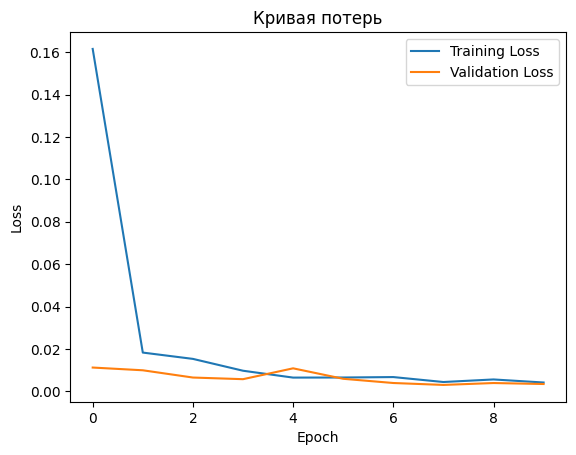

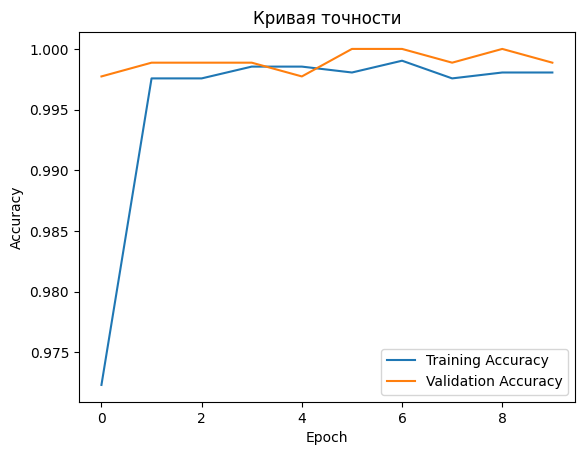

28/2828━━━━━━━━━━━━━━━━━━━  ━ 80ms/step━━━━━━━━━━━━━━━━━━━ 0s 5ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


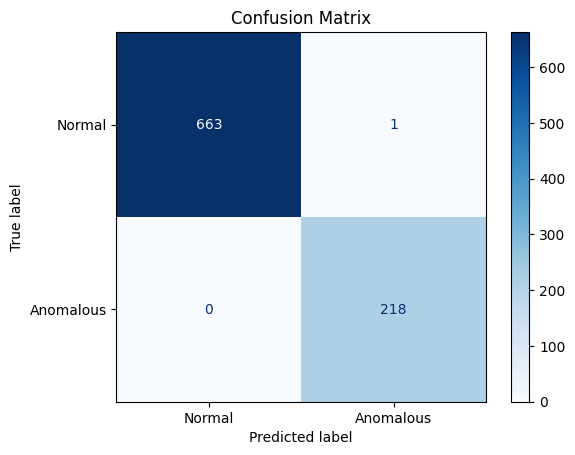

In [ ]:
import matplotlib.pyplot as plt

# Построение кривой потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Кривая потерь')
plt.show()

# Кривая точности
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Кривая точности')
plt.show()
# Используем обученную модель для предсказаний на тестовых данных
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Предсказания с порогом 0.5

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация с использованием ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()

c:\Users\Slyexistence\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
23/23━━━━━━━━━━━━━━━ 2/23  19s 885ms/step - accuracy: 0.4375 - loss: 0.7355━ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0s  2ms/step - accuracy: 0.4219 - loss: 0.72380s 880us/step - accuracy: 0.4514 - loss: 0.71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7430 - loss: 0.5838 - val_accuracy: 0.9612 - val_loss: 0.2168
Epoch 2/15
23/23━━━━━━━━━━━━━━━━━━━━  2/23 0s━ 17ms/step - accuracy: 0.9688 - loss: 0.2424 3/23  0s━━ 3ms/step - accuracy: 0.9766 - loss: 0.2220━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9774 - loss: 0.20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.1236 - val_accuracy: 0.9871 - val_loss: 0.0664
Epoch 3/15
23/233 2/23━━━━━━━━━━━━━━━━━━━━  ━━━━━━━━━━━━━━━━━━━━0s 11ms/step - accuracy: 1.0000 - loss: 0.0177  3/23 8ms/step - accuracy: 1.0000 - loss: 0.0161━━ ━━━━━━━━━━━━━━━━━━━━━ ━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.01520s 3ms/step - accuracy: 1.0000 - loss: 0.014 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.0

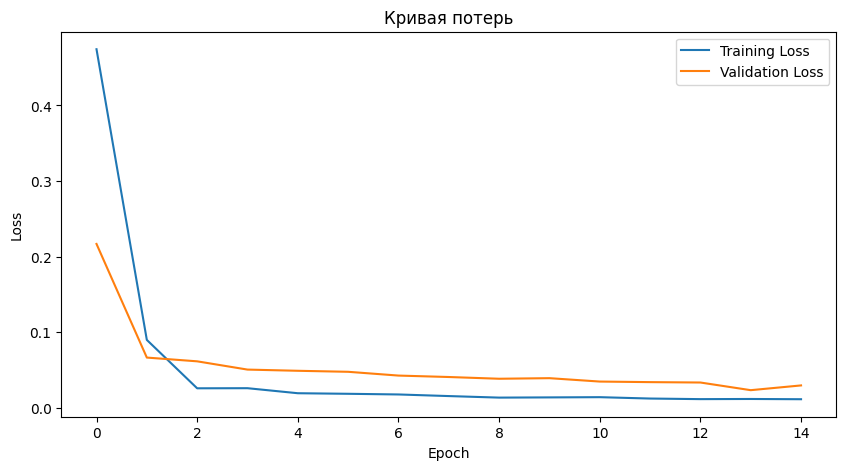

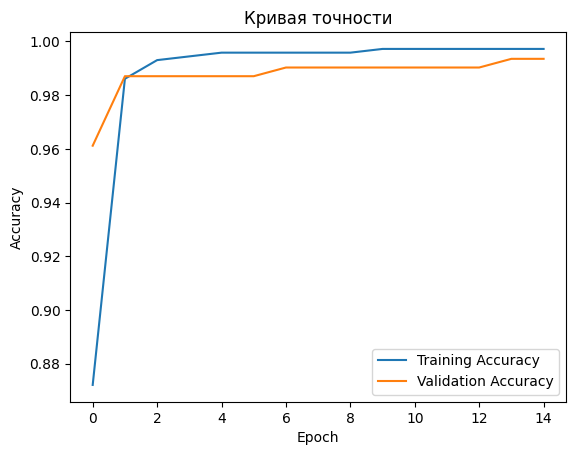

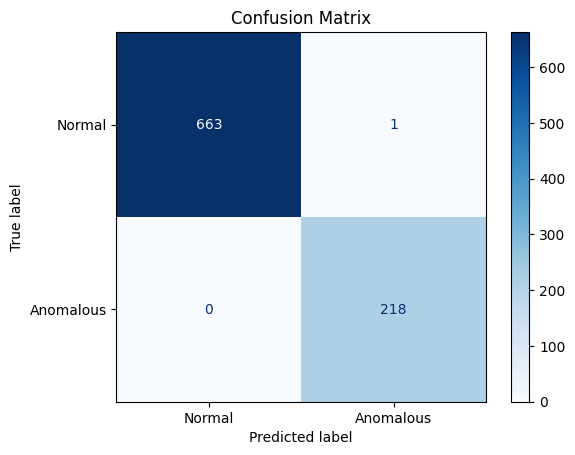

In [ ]:
from tensorflow.keras.layers import Dropout

# Масштабирование данных
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['label']))

# Формирование временных последовательностей
def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        sequence_labels.append(labels[i+sequence_length])
    return np.array(sequences), np.array(sequence_labels)

sequence_length = 10  # Длина последовательности
X, y = create_sequences(scaled_features, df['label'].values, sequence_length)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определение весов для классов
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Создание модели RNN с Dropout
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.5))  # Добавляем Dropout для отключения 20% нейронов
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели с указанием весов классов
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Точность: {accuracy * 100:.2f}%")

# Визуализация графиков
plt.figure(figsize=(10,5))

# Построение кривой потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Кривая потерь')
plt.show()

# Кривая точности
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Кривая точности')
plt.show()

# Визуализация с использованием ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()



In [ ]:
import visualkeras
visualkeras.layered_view(model)


c:\Users\Slyexistence\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
